# User Activeness Classification

A taxi company is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an rider share app account. We consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days. **The data was collected at the end of June 30, 2014.**
We would like to use this dataset to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help the company.
The data is in the attached file data_challenge.json. See below for a detailed
description of the dataset. 

**Data description**

city: city this user signed up in

phone: primary device for this user

signup_date: date of account registration; in the form ‘YYYYMMDD’

last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

avg_dist: the average distance in miles per trip taken in the first 30 days after signup

avg_rating_by_driver: the rider’s average rating over all of their trips

avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

surge_pct: the percent of trips taken with surge multiplier > 1

avg_surge: The average surge multiplier over all of this user’s trips

trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;

FALSE otherwise

weekday_pct: the percent of the user’s trips occurring during a weekday


In [1]:
#set up environment
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#load data and visualize
with open('train.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,Winterfell,1,2014-01-27,3.5,1.67,2014-06-22,iPhone,33.3,True,16.7,2.10,4.8
1,King's Landing,1,2014-01-11,5.0,1.00,2014-06-08,iPhone,0.0,False,0.0,7.30,5.0
2,King's Landing,0,2014-01-23,3.0,1.00,2014-06-27,iPhone,0.0,True,100.0,4.00,5.0
3,King's Landing,0,2014-01-17,4.0,1.00,2014-05-31,Android,0.0,False,33.3,6.73,5.0
4,King's Landing,1,2014-01-28,5.0,1.16,2014-06-20,iPhone,26.9,True,50.0,2.48,4.8


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47500 entries, 0 to 47499
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    47500 non-null  object 
 1   trips_in_first_30_days  47500 non-null  int64  
 2   signup_date             47500 non-null  object 
 3   avg_rating_of_driver    39746 non-null  float64
 4   avg_surge               47500 non-null  float64
 5   last_trip_date          47500 non-null  object 
 6   phone                   47128 non-null  object 
 7   surge_pct               47500 non-null  float64
 8   ultimate_black_user     47500 non-null  bool   
 9   weekday_pct             47500 non-null  float64
 10  avg_dist                47500 non-null  float64
 11  avg_rating_by_driver    47311 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.4+ MB


In [3]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,47500.000000,39746.000000,47500.000000,47500.000000,47500.000000,47500.000000,47311.000000
mean,2.275158,4.602186,1.074716,8.852829,60.966623,5.799024,4.778400
std,3.789220,0.617603,0.222291,19.993570,37.064133,5.677958,0.447863
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.890000,5.000000
75%,3.000000,5.000000,1.050000,8.500000,100.000000,6.950000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,129.890000,5.000000


### 1. EDA
a. First of all, all the users will need to be labled by active or inactive, and categorical variables must be encoded. The null values must be accounted for. While the reason for the missing ratings cannot be inferred, it seems reasonable that the user/driver simply declined to input a rating. In this case, we will fill with the **mean value** so as to not affect the current distribution, which is primarily high ratings.

In [4]:
df["avg_rating_of_driver"].isna().sum()

7754

In [5]:
df["avg_rating_by_driver"].isna().sum()

189

In [6]:
#fill missing values in avg_rating_by_driver and avg_rating_of_driver
mean_of = df['avg_rating_of_driver'].mean()
mean_by = df['avg_rating_by_driver'].mean()
df['avg_rating_of_driver'].fillna(value=mean_of, inplace=True)
df['avg_rating_by_driver'].fillna(value=mean_by, inplace=True)
(df["avg_rating_of_driver"].isna().sum(), df["avg_rating_by_driver"].isna().sum())

(0, 0)

b. The target variable will be whether the user was active. Convert the signup date and last trip date to datetime objects. If the last trip is in June, then encode each user active as True, else False.

In [7]:
#set as datatime objects
df["signup_date"] = pd.to_datetime(df["signup_date"])
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"])

In [8]:
df["signup_date"].dt.year.describe()

count    47500.0
mean      2014.0
std          0.0
min       2014.0
25%       2014.0
50%       2014.0
75%       2014.0
max       2014.0
Name: signup_date, dtype: float64

In [9]:
df["last_trip_date"].dt.month

0        6
1        6
2        6
3        5
4        6
        ..
47495    1
47496    6
47497    6
47498    5
47499    6
Name: last_trip_date, Length: 47500, dtype: int64

In [10]:
df['active'] = df["last_trip_date"].dt.month == 6

#### Ratio of Active Users to Inactive Users

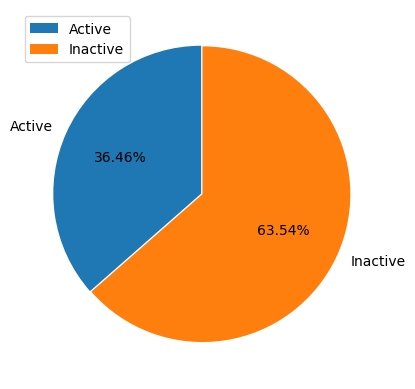

In [11]:
#Calculate ratio of active to all users
active_ratio = df['active'].sum() / df.shape[0]
#Visualization
ratios = np.array([active_ratio, 1 - active_ratio])
plt.pie(ratios, labels = ["Active", "Inactive"], autopct=lambda p: '{:.2f}%'.format(p), explode = [0.01, 0], startangle=90)
plt.legend(loc='upper left')
plt.show()

Unsurprisingly the classes are imbalanced, but not tremendously. This should not present too much of a problem while modeling.

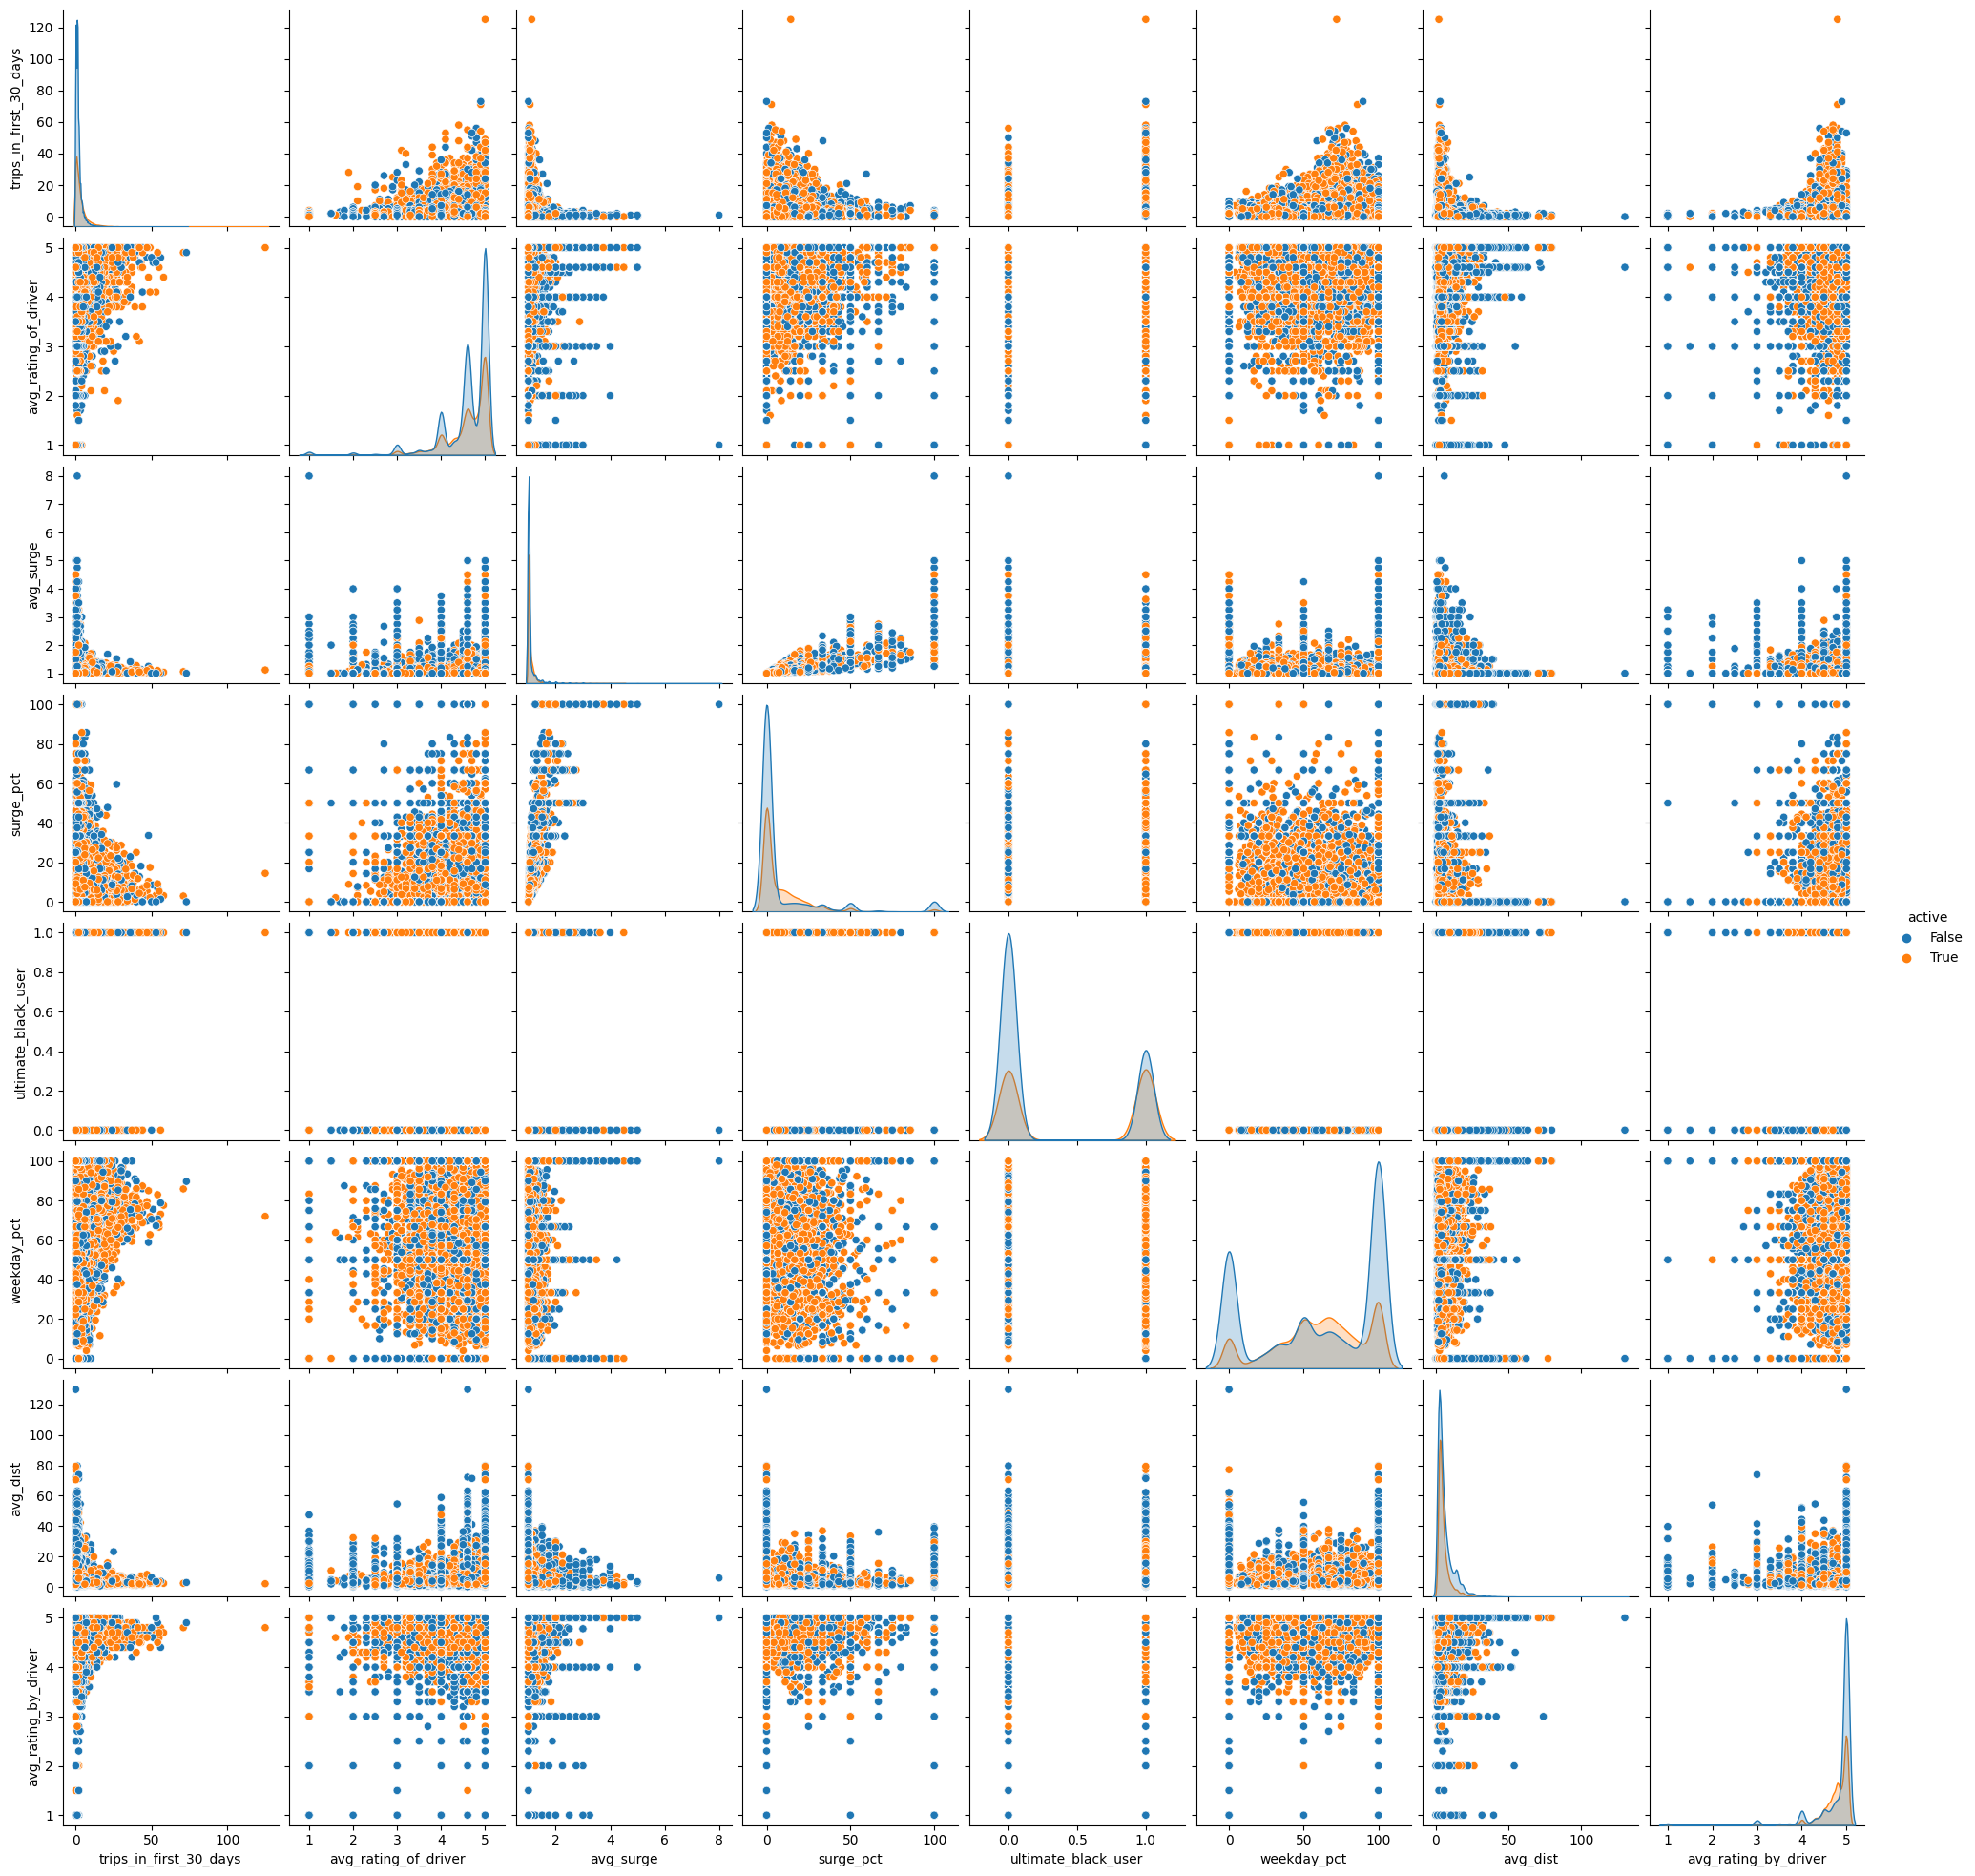

In [12]:
sns.pairplot(df, hue = 'active')

According to the pair plots, it can be clearly found that there is a relationship between ``active`` and other variables, for specifically, linear combination of other variables. For example, there is a clear relationship between the value of ``active`` and the linear combination of ``avg_surge`` and ``avg_rating of driver``, according to the pair plots. The plots also indicate that many of the variables are not normally distributed.

In [13]:
from scipy import stats
_, lambda1 = stats.boxcox(df['trips_in_first_30_days'] + 1)
_, lambda2 = stats.boxcox(df['avg_rating_of_driver'])
_, lambda3 = stats.boxcox(df['avg_surge'])
_, lambda4 = stats.boxcox(df['surge_pct'] + 0.01)
_, lambda5 = stats.boxcox(df['weekday_pct'] + 0.01)
_, lambda6 = stats.boxcox(df['avg_dist'] + 0.01)
_, lambda7 = stats.boxcox(df['avg_rating_by_driver'])

In [14]:
(lambda1, lambda2, lambda3, lambda4, lambda5, lambda6, lambda7)

(-0.4329558017611663,
 6.65334114930362,
 -13.015663736700569,
 -0.32889962593416766,
 0.47347063069459255,
 0.1504293623927204,
 12.838903596250056)

In [15]:
df['trips_in_first_30_days'] = np.log(df['trips_in_first_30_days'] + 1)
df['avg_rating_of_driver'] = np.power(df['avg_rating_of_driver'], 7)
df['avg_surge'] = np.power(df['avg_surge'], -13)
df['surge_pct'] = np.log(df['surge_pct'] + 0.01)
df['weekday_pct'] = np.log(df['weekday_pct'] + 0.01)
df['avg_dist'] = np.log(df['avg_dist'] + 0.01)
df['avg_rating_by_driver'] = np.power(df['avg_rating_by_driver'], 13)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'surge_pct', 'avg_surge', 'trips_in_first_30_days', 'weekday_pct']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

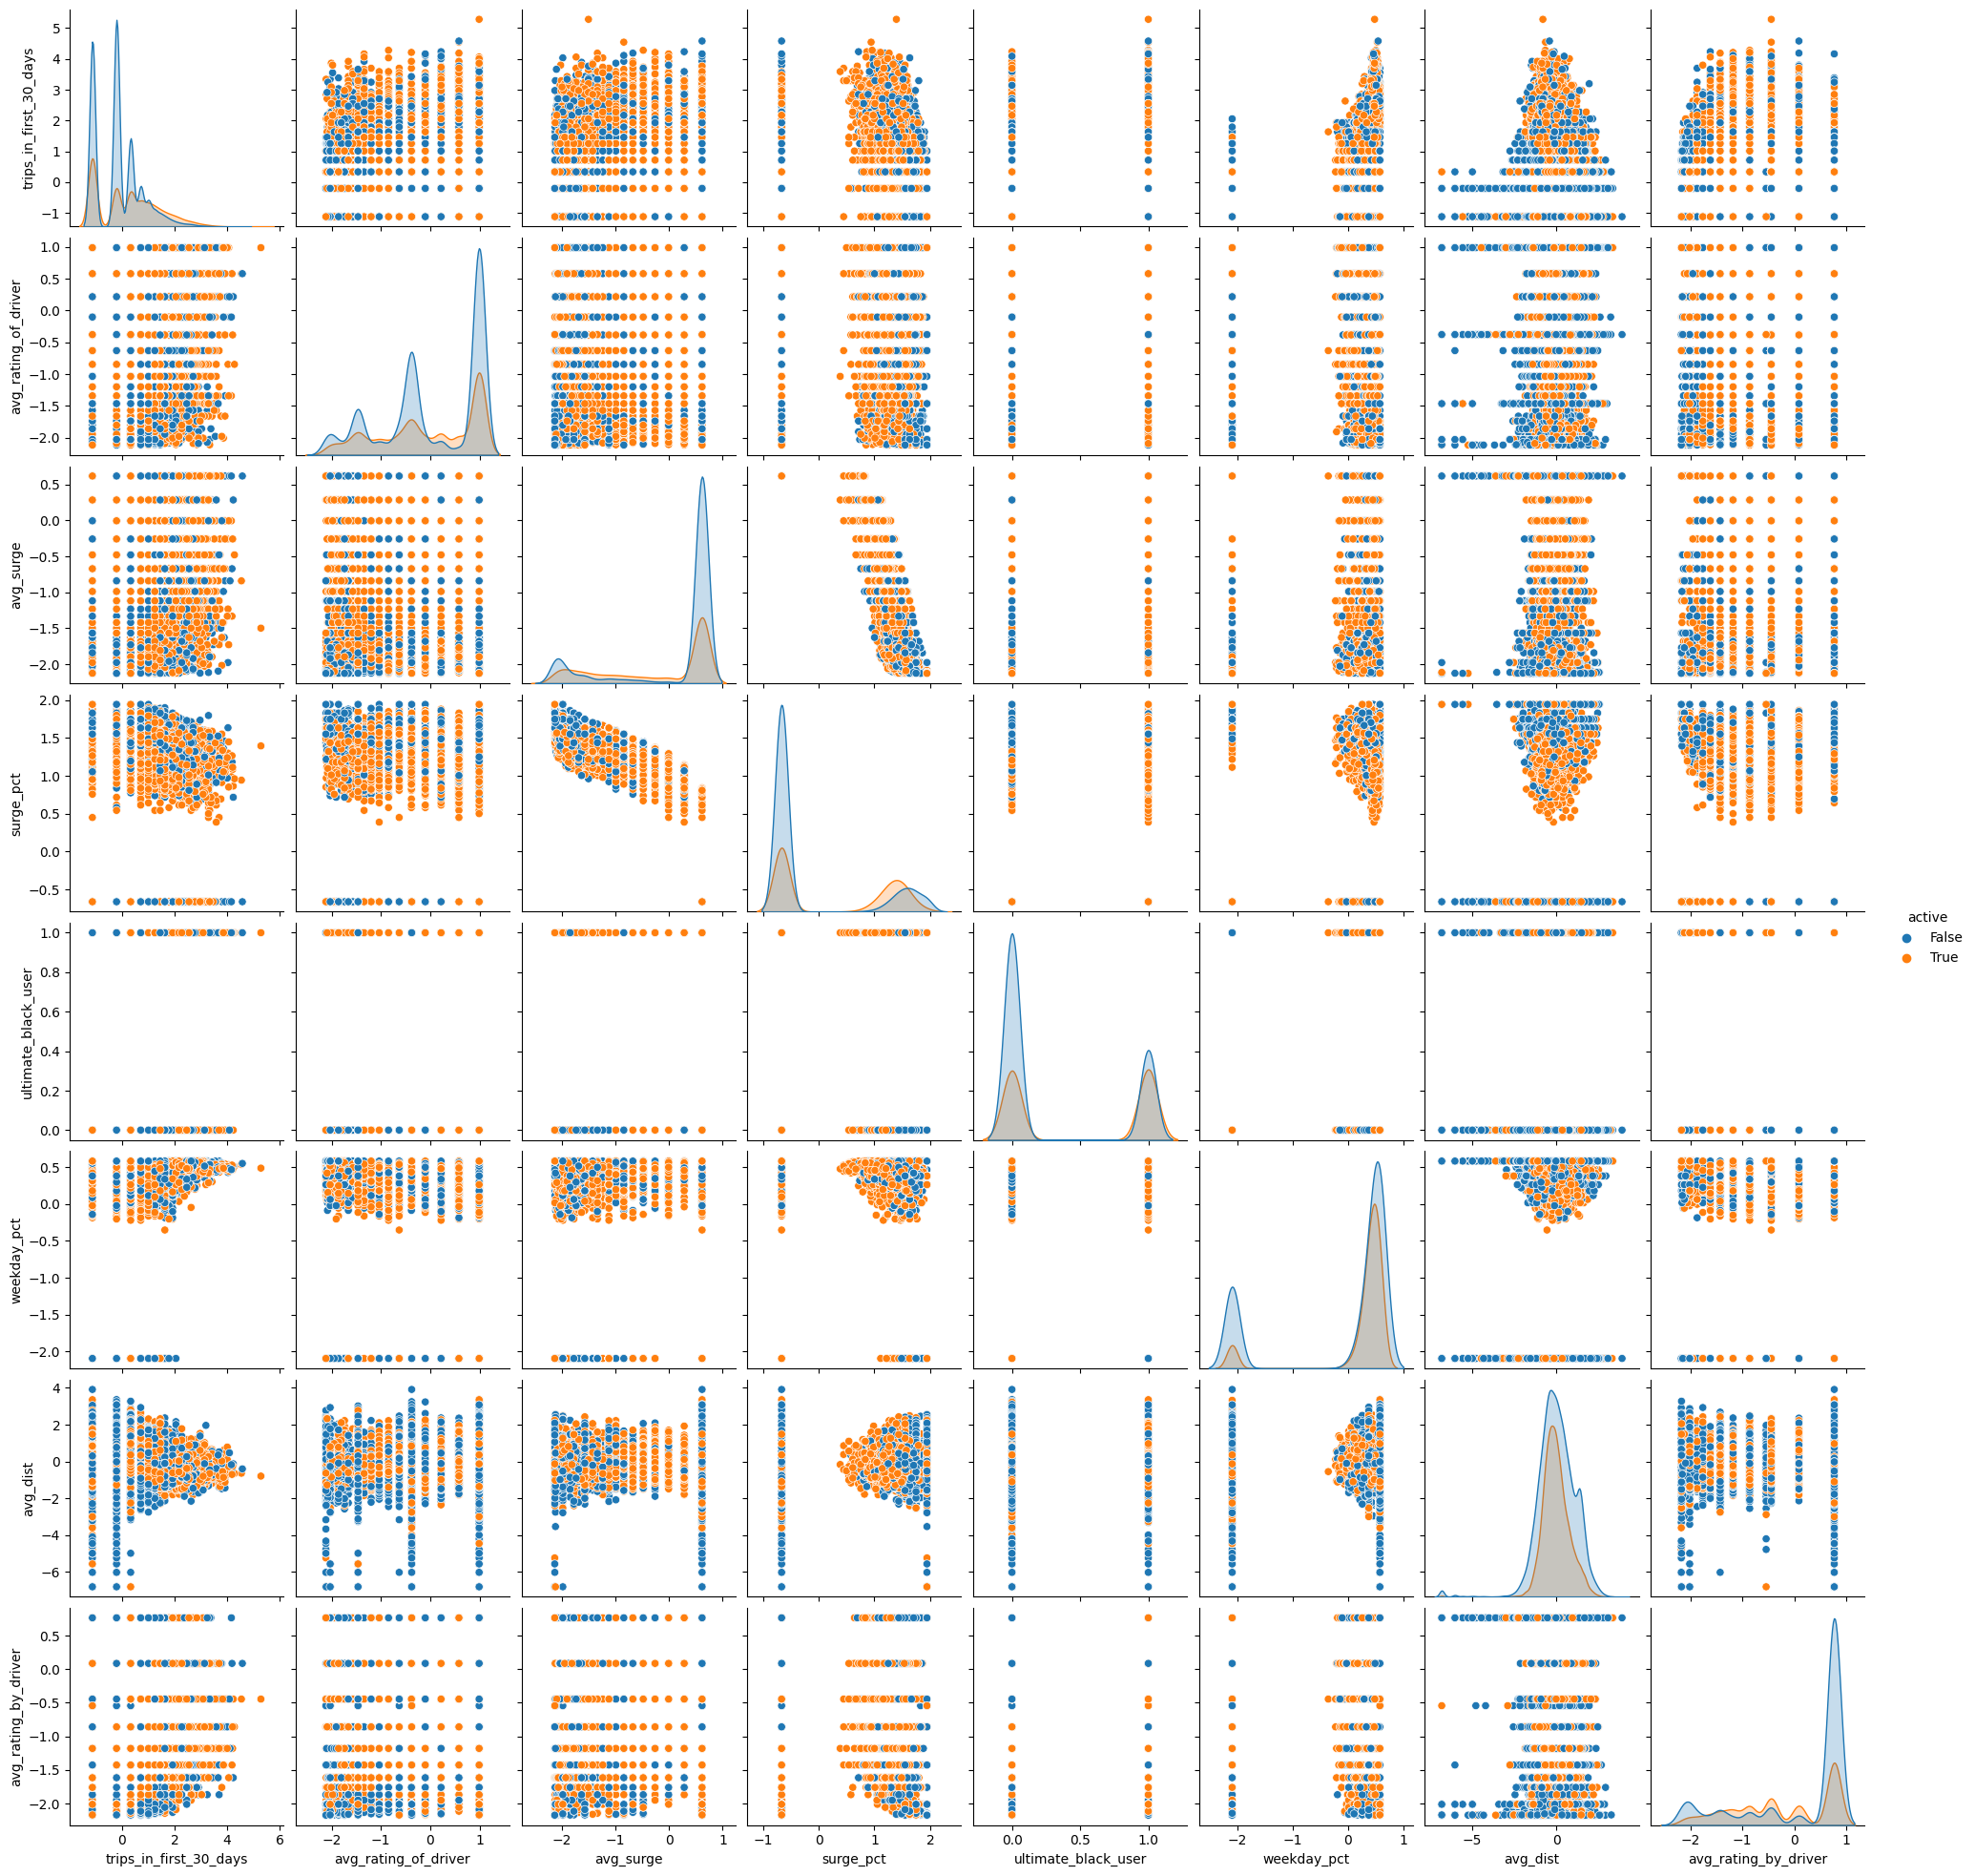

In [16]:
sns.pairplot(df, hue = 'active')

With Boxcox method, we try to normalize the numerical variables, and according to the figures, the distribution turns out to better fit the normal distribution.

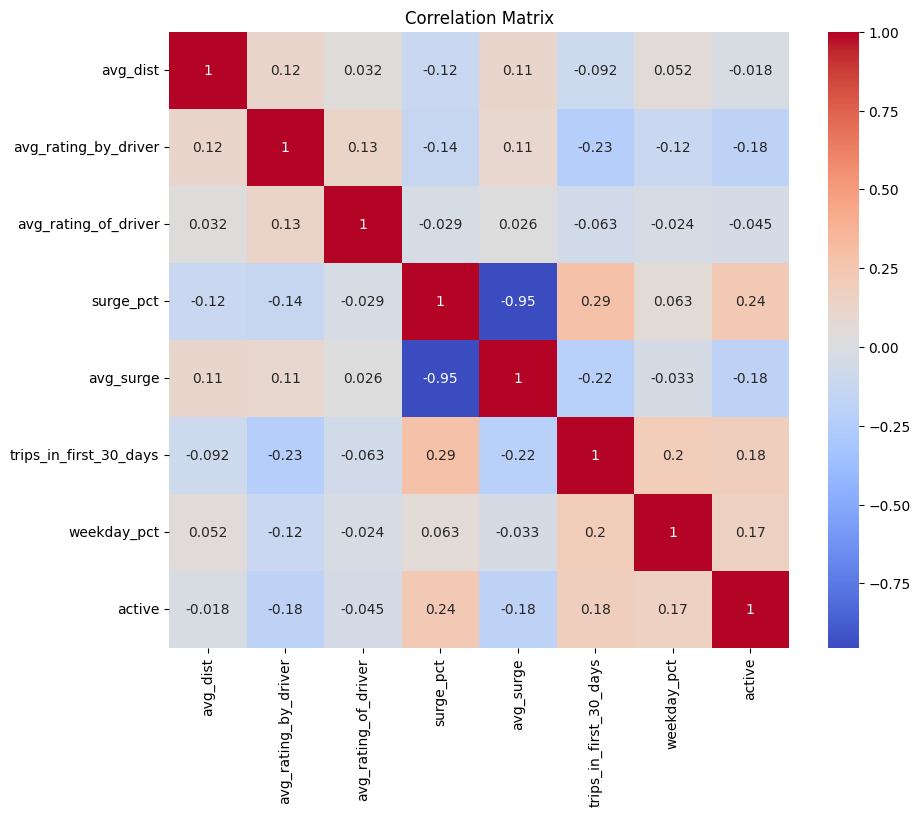

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_features + ['active']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

It can be found that ``surge_pct`` and ``avg_surge`` are highly correlated. As ``surge_pct`` is more correlated to ``active``, we'll select ``surge_pct`` over ``avg_surge``. As ``avg_rating_of_driver`` seems to have no correlation with any other variable, we'll remove it from the list.

In [18]:
df['city'].describe()

count          47500
unique             3
top       Winterfell
freq           22138
Name: city, dtype: object

In [19]:
df['phone'].describe()

count      47128
unique         2
top       iPhone
freq       32848
Name: phone, dtype: object

In [20]:
from sklearn.preprocessing import OneHotEncoder

def ohe_city(data):
    """
    One-hot-encodes roof material.  New columns are of the form 0x_QUALITY.
    """
    def custom_combiner(feature, category):
        return str(feature) + "_" + str(category)
    ## One Hot Encode City
    enc = OneHotEncoder(feature_name_combiner=custom_combiner).fit(data[['city']])
    new_cols = pd.DataFrame(
        enc.transform(data[['city']]).todense(),
        columns=enc.get_feature_names_out(),
        index=data.index
    )
    data = data.join(new_cols)
    ## One Hot Encode Phone
    enc = OneHotEncoder(feature_name_combiner=custom_combiner).fit(data[['phone']])
    new_cols = pd.DataFrame(
        enc.transform(data[['phone']]).todense(),
        columns=enc.get_feature_names_out(),
        index=data.index
    )
    data = data.join(new_cols)
    return data

df = ohe_city(df)
df.filter(regex='^(city|phone)').head(10)

,city,phone,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_None
0,Winterfell,iPhone,0.0,0.0,1.0,0.0,1.0,0.0
1,King's Landing,iPhone,0.0,1.0,0.0,0.0,1.0,0.0
2,King's Landing,iPhone,0.0,1.0,0.0,0.0,1.0,0.0
3,King's Landing,Android,0.0,1.0,0.0,1.0,0.0,0.0
4,King's Landing,iPhone,0.0,1.0,0.0,0.0,1.0,0.0
5,Winterfell,iPhone,0.0,0.0,1.0,0.0,1.0,0.0
6,Winterfell,iPhone,0.0,0.0,1.0,0.0,1.0,0.0
7,Astapor,iPhone,1.0,0.0,0.0,0.0,1.0,0.0
8,Winterfell,Android,0.0,0.0,1.0,1.0,0.0,0.0
9,Winterfell,iPhone,0.0,0.0,1.0,0.0,1.0,0.0


In [21]:
X = df.drop(['active', 'city', 'phone', 'signup_date', 'last_trip_date', 'city_Winterfell', 'phone_None', 'phone_Android', 'avg_surge', 'avg_rating_of_driver'], axis=1)
y = df['active']

In [22]:
categoricals = ["city_Astapor", "city_King's Landing", "phone_iPhone", "ultimate_black_user"]
numericals = ["trips_in_first_30_days", "surge_pct", "weekday_pct", "avg_dist", "avg_rating_by_driver"]
for categorical in categoricals:
    for numerical in numericals:
        X[categorical + "_" + numerical] = X[categorical] * X[numerical]

We conduct One Hot Encoding on the categorical variables, and add all interactions into the dataframe.

## 2. Modeling

In [23]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# Train a Random Forest Classifier on the entire dataset
clf = XGBClassifier(n_estimators=500, learning_rate=0.2)
clf.fit(X, y)

# Get the feature importances
feature_importances = clf.feature_importances_

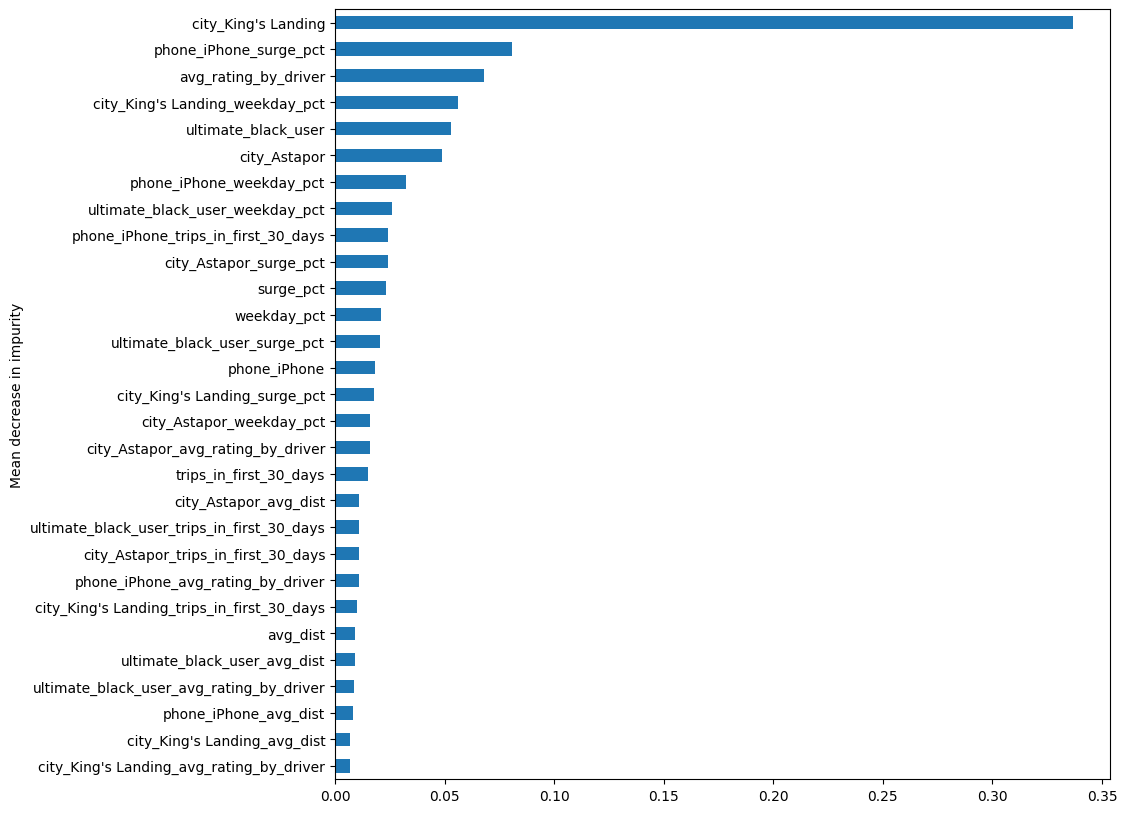

In [24]:
plt.figure(figsize=(10,10))
importances = pd.Series(clf.feature_importances_, index= X.columns)
importances.sort_values(ascending = True).plot.barh()
plt.ylabel("Mean decrease in impurity")
plt.show()

The figure shows the significance level of each variable (predictor) in a XGBClassifier. We'll sort the predictors based on the significance level, and select the best effective number of variables to predict the target value.

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4710)

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score

In [ ]:
variable_nums = range(1, X.shape[1] + 1)
scores = []
variables = importances.sort_values(ascending = False).keys()
for variable_num in variable_nums:
    filtered_features = variables[:variable_num]
    test_model = XGBClassifier(n_estimators=200, learning_rate=0.2)
    clf.fit(X[filtered_features], y)
    pred = clf.predict(X[filtered_features])
    scores.append(accuracy_score(y, pred))

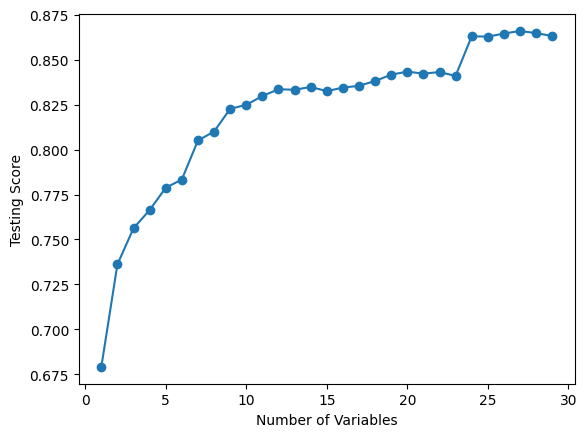

In [ ]:
plt.plot(variable_nums, scores, marker='o')
plt.xlabel('Number of Variables')
plt.ylabel('Testing Score')
plt.show()

It can be observed that the cross validation performance keeps increases and reaches the maximum at about 24, then keeps about the same. Therefore, we should select the 24 most significant variables to predict the target value. But as we only have 30 in total. It doesn't make a great difference.

In [28]:
filtered_features = variables

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Define pipelines for each model
pipelines = {
    'logistic_regression': Pipeline([('imputer', SimpleImputer()), ('scaler', StandardScaler()), 
        ('classifier', LogisticRegression())]),
    'random_forest': Pipeline([('imputer', SimpleImputer()), ('scaler', StandardScaler()), 
        ('classifier', RandomForestClassifier(n_estimators=100))]),
    'xgboost': Pipeline([('imputer', SimpleImputer()), ('scaler', StandardScaler()), 
        ('classifier', XGBClassifier(n_estimators=100, learning_rate=0.1))])
}

# Evaluate each model using cross-validation
for model_name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X[filtered_features], y, cv=5, scoring='accuracy')
    print(f'{model_name} accuracy: {scores.mean()} +/- {scores.std()}')

logistic_regression accuracy: 0.742 +/- 0.0032526145460293385
random_forest accuracy: 0.7380842105263158 +/- 0.0020186389095356735
xgboost accuracy: 0.7806736842105263 +/- 0.0018312159349880073


In [30]:
filtered_features = categoricals + numericals

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Define pipelines for each model
pipelines = {
    'logistic_regression': Pipeline([('imputer', SimpleImputer()), ('scaler', StandardScaler()), 
        ('classifier', LogisticRegression())]),
    'random_forest': Pipeline([('imputer', SimpleImputer()), ('scaler', StandardScaler()), 
        ('classifier', RandomForestClassifier(n_estimators=100))]),
    'xgboost': Pipeline([('imputer', SimpleImputer()), ('scaler', StandardScaler()), 
        ('classifier', XGBClassifier(n_estimators=100, learning_rate=0.1))])
}

# Evaluate each model using cross-validation
for model_name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X[filtered_features], y, cv=5, scoring='accuracy')
    print(f'{model_name} accuracy: {scores.mean()} +/- {scores.std()}')

logistic_regression accuracy: 0.7392842105263158 +/- 0.0036527377506183505
random_forest accuracy: 0.7397684210526316 +/- 0.0019138220088190923
xgboost accuracy: 0.7828631578947368 +/- 0.0008082675292822314


It turns out the xgboost performs the best among the three models. Therefore, we'll select XGBoost as our model.

### XGBoost

In [32]:
from sklearn.model_selection import RandomizedSearchCV

# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier())
])

# Define hyperparameter distributions to search over
param_distributions = {
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.5, 1, 2, 5],
    'classifier__n_estimators': [100, 200, 500, 1000, 2000],
    'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'classifier__subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'classifier__colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'classifier__gamma': [0.01, 0.1, 0.2, 0.5, 1],
    'classifier__reg_alpha': [0.01, 0.1, 0.2, 0.5, 1],
    'classifier__reg_lambda': [0.01, 0.1, 0.2, 0.5, 1]
}

# Perform randomized search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=4710
)

# Fit the model on training data
random_search.fit(X[filtered_features], y)

# Evaluate the best model on test data
print("Best score:", random_search.best_score_)
print("Best params:", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best score: 0.7845052631578947
Best params: {'classifier__subsample': 0.7, 'classifier__reg_lambda': 0.2, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 500, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.01, 'classifier__colsample_bytree': 0.7}



## 3. Model Evaluation

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

clf = XGBClassifier(
    colsample_bytree=random_search.best_params_['classifier__colsample_bytree'],
    gamma=random_search.best_params_['classifier__gamma'],
    learning_rate=random_search.best_params_['classifier__learning_rate'],
    max_depth=random_search.best_params_['classifier__max_depth'],
    n_estimators=random_search.best_params_['classifier__n_estimators'],
    reg_alpha=random_search.best_params_['classifier__reg_alpha'],
    reg_lambda=random_search.best_params_['classifier__reg_lambda'],
    subsample=random_search.best_params_['classifier__subsample'],
    random_state=4710
)

clf.fit(X_train[filtered_features], y_train)
y_pred = clf.predict(X_test[filtered_features])

In [34]:
y_pred.shape

(9500,)

In [35]:
print(classification_report(y_test, y_pred))
print("balanced accuracy score:", balanced_accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.85      0.83      5996
        True       0.73      0.67      0.70      3504

    accuracy                           0.79      9500
   macro avg       0.77      0.76      0.77      9500
weighted avg       0.78      0.79      0.78      9500

balanced accuracy score: 0.7629476538392415
[[5116  880]
 [1147 2357]]


Accuracy: measures the proportion of correct predictions. Usually applied on balanced sets.

Precision: measures the proportion of true positives among the predicted positives. Usually applied to avoid false positives.

Recall: measures the proportion of true positives among the actual positives. Usually applied to avoid false negatives.

F1 score: measures the harmonic mean of precision and recall. Usually applied to balance both precision and recall.

Balanced Accuracy: measures the balanced accuracy. Usually applied on unbalanced data.

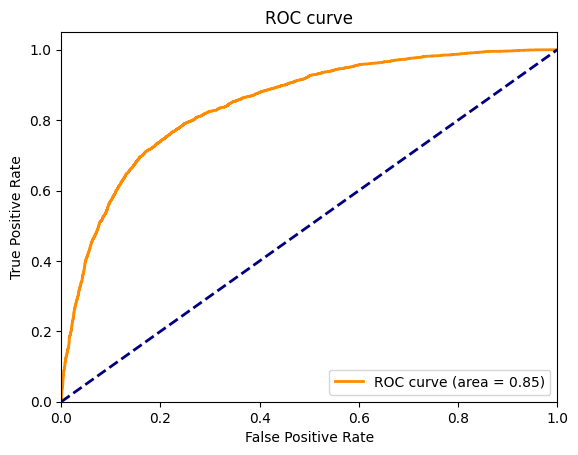

In [36]:
from sklearn.metrics import roc_curve, auc

y_score = clf.predict_proba(X_test[filtered_features])[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

The ROC curve indicates that our model has a good performance due to its smoothness and curveness. The area of the ROC curve is 0.85, which is close to 1, which further indicates that our model behaves nicely.

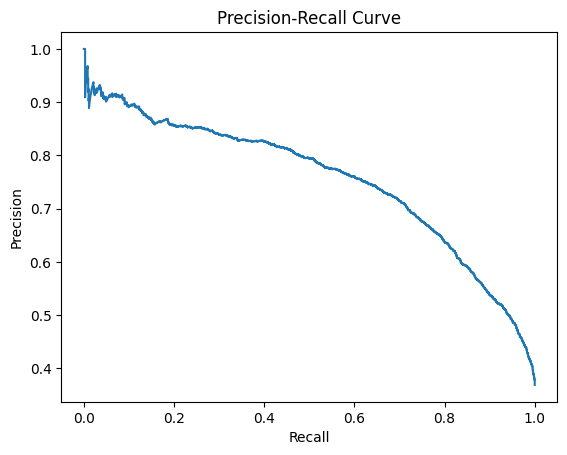

In [37]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## Final Submission



In [38]:
test = pd.read_csv('test.csv')

test['trips_in_first_30_days'] = np.log(test['trips_in_first_30_days'] + 1)
test['avg_rating_of_driver'] = np.power(test['avg_rating_of_driver'], 7)
test['avg_surge'] = np.power(test['avg_surge'], -13)
test['surge_pct'] = np.log(test['surge_pct'] + 0.01)
test['weekday_pct'] = np.log(test['weekday_pct'] + 0.01)
test['avg_dist'] = np.log(test['avg_dist'] + 0.01)
test['avg_rating_by_driver'] = np.power(test['avg_rating_by_driver'], 13)

numeric_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'surge_pct', 'avg_surge', 'trips_in_first_30_days', 'weekday_pct']
test[numeric_features] = scaler.transform(test[numeric_features])

test = ohe_city(test)

clf.fit(X[filtered_features], y)
test_predictions = clf.predict(test[filtered_features])

In [39]:
submission_df = pd.DataFrame({ 
    "active": test_predictions
}, columns=['active'])
submission_df.to_csv("submission.csv", index=False)

Created a CSV file: submission.csv
You may now upload this CSV file to Gitea for grading.
